In [25]:
import json
import os
import shutil
from datetime import datetime, timedelta

import numpy as np
import scipy
import strax
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4

import helix as hx
from helix import units

# methods and classes marked with the @export decorator are added to the __all__ namespace to make them importable via
# the star-notation ('from .module_name import *')
export, __all__ = strax.exporter()


@export
def get_pink_psd(trace_length, sampling_dt, noise_std):
    """
    Returns folded PSD corresponding to 1/f pink noise, empirically scaled to make the standard deviation of the noise
    produced from this PSD to be close to the provided noise_std value

    :param trace_length: length of noise traces in samples
    :param sampling_dt: sampling time in ns
    :param noise_std: noise standard deviation
    :return: a tuple of (f, psd), where f is the array of frequencies in Hz, and psd is the array of PSD components
    in A^2/Hz. Can be plotted with plt.loglog(f, psd)
    """
    f = scipy.fft.rfftfreq(trace_length, d=sampling_dt / units.s)
    f[0] = f[1]
    # empirical approximate scaling to match the standard deviation of the resulting noise.
    # This is totally crazy, it's a random expression that scales the PSD in a way that the standard deviation of the
    # noise produced from this PSD somewhat matches the requested noise_std
    # TODO: derive the actual scaling that would properly work and make sense instead of this monster
    scaling = 1 / (1 + (np.log10(trace_length) - 4.5) / 10) ** 2 / 10.3
    psd = scaling*(noise_std**2) / f
    psd[-1] = psd[-1] / 2
    # Could use 0 for the DC component of the PSD, but it messes up the plotting in log scale.
    # The value doesn't matter anyway, we are not generating noise DC components. Using the smallest positive float
    psd[0] = np.nextafter(1, 2)
    f[0] = 0
    return f, psd

def generate_silent_traces(n_traces, psd, sampling_frequency=1.0):
    """
    Function to generate silent traces (zeros) with the same structure as the noise generator.
    :param n_traces: int. Number of traces to generate.
    :param psd: ndarray. Folded power spectral density (not used, but kept for structure consistency).
    :param sampling_frequency: float. Sample frequency in Hz.
    :returns: ndarray. An array of silent (zero) traces.
    """
    trace_length = hx.psd_to_trace_length(len(psd))
    
    # Generate an array of zeros with the appropriate shape
    silent_traces = np.zeros((n_traces, trace_length))
    
    return silent_traces
@export
def load_traces_from_csv(file_path):
    """
    Reads the CSV file containing traces and returns them as a NumPy array.
    :param file_path: str. Path to the CSV file.
    :returns: ndarray. Array of traces with shape (n_traces, 32768).
    """
    traces_df = pd.read_csv(file_path, header=None)
    traces_array = traces_df.to_numpy(dtype=np.float32)
    return traces_array
    
def generate_toy_data(run, duration, directory='toy_data', record_length=hx.DEFAULT_RECORD_LENGTH,
                      sampling_dt=hx.DEFAULT_SAMPLING_DT, template_length=hx.DEFAULT_TEMPLATE_LENGTH,
                      channel_map=hx.DEFAULT_CHANNEL_MAP, noise_std=3, event_rate=3, lone_hit_rate=2,
                      muon_rate=0.1, overwrite=False, helix_data_dir='test_helix_data', baseline_step=0, traces_file='traces.csv'):
    """
    Generates and saves toy data with multiple channels of vacuum and submerged types, physics events consisting of UV
    and QP signals, as well as background lone hits and muon saturated events. CAUTION: it's slow!
    Noise is uncorrelated pink noise, with a correlated 5 kHz feature in all channels. Channels have different baselines

    :param run: run id
    :param duration: run duration in seconds. Caution: the function is slow, don't ask to generate days of data
    :param directory: output directory, where a directory with run_id name will be created
    :param record_length: length of records in each file in time samples
    :param sampling_dt: sampling time in ns
    :param template_length: length of UV and QP templates
    :param channel_map: dictionary of channel types and channel number ranges
    :param noise_std: standard deviation of the noise
    :param event_rate: rate of physics events in Hz
    :param lone_hit_rate: rate of lone background hits in Hz (events with a UV signal in only one channel)
    :param muon_rate: rate of muon events
    :param overwrite: a boolean specifying whether the function should overwrite data, if it already exists. If False,
    a RuntimeError is raise when a directory with the same run id exists
    :param helix_data_dir: a directory to save the run metadata. Should be the same as the helix output directory.
    :param baseline_step: add a baseline to each channel, equal to baseline_step * channel_index
    """

    traces_array = load_traces_from_csv(traces_file)
    run_dir = os.path.join(directory, run)
    if os.path.exists(run_dir):
        if overwrite:
            shutil.rmtree(run_dir)
        else:
            raise RuntimeError(f'Directory {run_dir} already exists.')

    os.makedirs(run_dir)

    record_length_s = record_length * sampling_dt / units.s
    qp_template = hx.get_analytical_template(2 * units.ms, length=template_length, sampling_dt=sampling_dt)


    n_records = int(duration / record_length_s)
    channels = hx.Channels(channel_map)
    n_channels = len(channels)
    n_submerged_channels = channels.counts[hx.ChannelType.SUBMERGED]
    n_vacuum_channels = channels.counts[hx.ChannelType.VACUUM]
    batch_size = 5  # number of records per batch
    sampling_frequency = 1 / (sampling_dt / units.s)

    _, psd = get_pink_psd(record_length * batch_size, sampling_dt, noise_std)

    correlated_freq = 5e3  # Hz
    correlated_noise_amp = noise_std/5

    # adding different baselines to each channel
    baseline = baseline_step * np.arange(n_channels)

    n_batches = int(np.ceil(n_records / batch_size))
    correlated_phases = np.random.uniform(0, 2 * np.pi, n_batches)

    batch_length_s = batch_size * record_length_s
    n_events = np.random.poisson(event_rate*batch_length_s, n_batches)
    n_lone_hits = np.random.poisson(lone_hit_rate*batch_length_s, n_batches)
    n_muons = np.random.poisson(muon_rate*batch_length_s, n_batches)

    # mean and max time intervals between UV and QP signals
    mean_qp_shift = int(1 * units.ms / sampling_dt)
    max_qp_shift = 2 * mean_qp_shift

    uv_photon_energy = 15
    max_adc = 10000
    ev_to_adc = 10

    for i in tqdm(range(n_batches)):
        # generating noise and adding a correlated feature to it
        waveform = generate_silent_traces(n_channels, psd, sampling_frequency)
        # generate random event times
        event_times = np.random.randint(0, batch_size * record_length - template_length - max_qp_shift,
                                        size=n_events[i])
        


        # adding physics events and muons to the traces
        for ich, ch_type in enumerate(channels.types):
            for j in range(n_events[i]):
                if ch_type == hx.ChannelType.VACUUM:
                    trace_idx = j % traces_array.shape[0]  # Assign one real trace per event
                    selected_trace = traces_array[trace_idx]
                    start_idx = event_times[j] 
                    end_idx = min(start_idx + 32768, waveform.shape[1])
                    waveform[ich, event_times[j]:event_times[j] + hx.DEFAULT_TEMPLATE_LENGTH] +=\
                        selected_trace[:end_idx - start_idx]
                    



        # clipping the traces to simulate saturation
        waveform = np.clip(waveform*ev_to_adc, -max_adc, max_adc)

        # splitting the data into record_length records
        for j in range(batch_size):
            i_record = i * batch_size + j
            if i_record == n_records:
                break
            fn = f'{directory}/{run}/{run}-{i_record:05d}'
            # saving the data as a flattened array
            with open(fn, mode='wb') as f:
                data = np.ascontiguousarray(waveform[:, j * record_length:(j + 1) * record_length], dtype=np.int16)
                f.write(lz4.compress(data))

    # saving run metadata
    if not os.path.exists(helix_data_dir):
        os.makedirs(helix_data_dir)

    metadata_path = os.path.join(helix_data_dir, "%s-metadata.json" % run)
    start = datetime.now().replace(microsecond=0)
    end = start + timedelta(seconds=duration)
    metadata = {'start': start, 'end': end}
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, default=json_util.default)


In [26]:
import numpy as np
import strax as sx
import numba
import pandas as pd
import scipy as sp
import sys
import os
import helix as hx
import shutil
from glob import glob
from matplotlib import pyplot as plt

run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel
# remove helix data corresponding to this run_id, if it exists
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


In [27]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 1}                 # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type


Loading events: |                     | 0.00 % [00:14<?], #2 (7.22 s). 41.0 MB/s


Source finished!


Loading fit_results: |                 | 0.00 % [00:09<?], #3 (2.90 s). 7.4 kB/s


In [28]:
raw_data.shape

(39, 50, 33168)

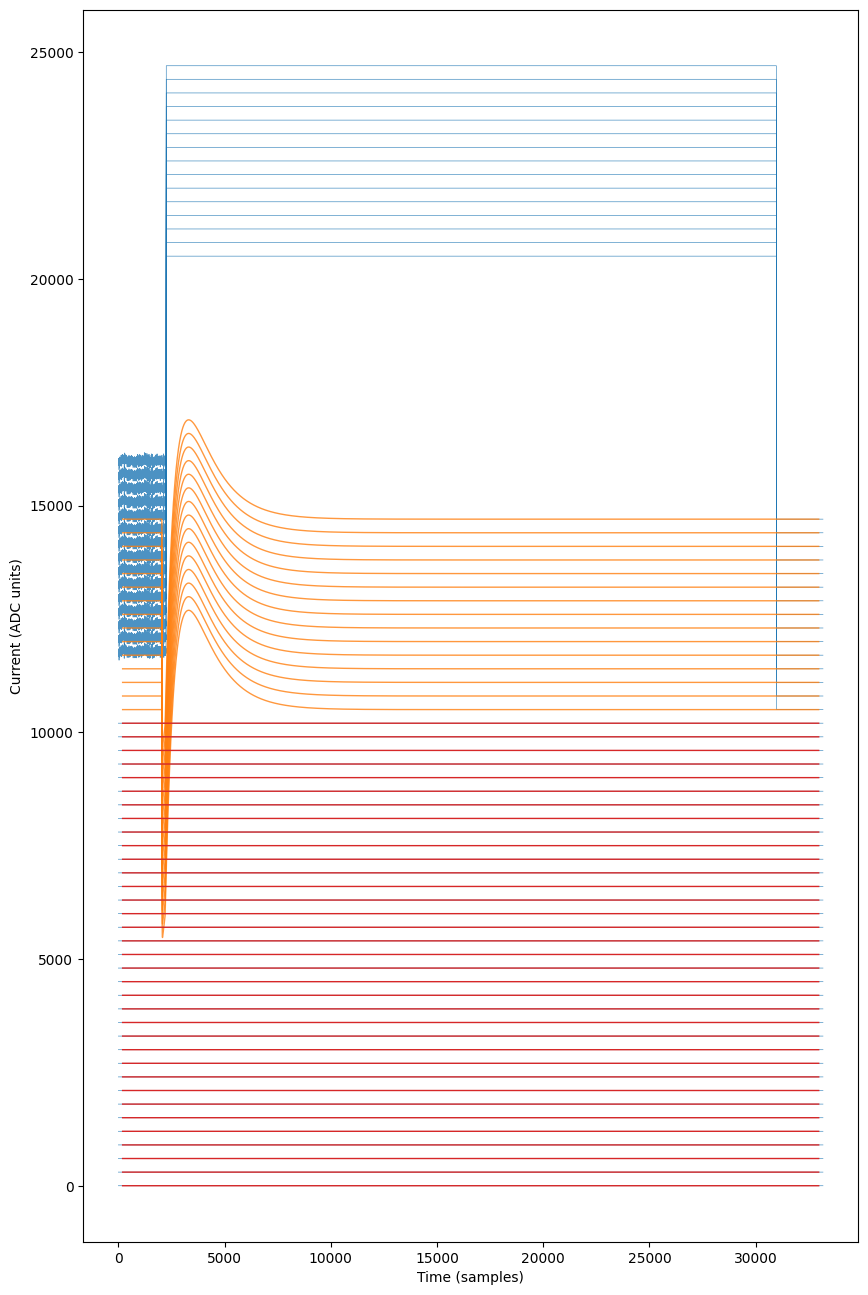

In [29]:
# Building the channel map and loading the templates
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

template_path = './plugins/event_rqs/default_templates.npy'
templates = np.load(template_path, allow_pickle=True)
uv_template = templates[0]
qp_template = templates[1]
# change this to choose another event if the one below is a bad one by chance
i = 7

plt.figure(figsize=(10,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel

event = fit_results[i]

# plotting two-template fits in the vacuum channels
for i_vac, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.VACUUM)):
    # i_vac is the ordinal index of the vacuum channel
    # i_ch is the corrending ordinal index in the array of all channels
    fit = event['vacuum_channel_uv_amplitude'][i_vac] * np.roll(uv_template, event['vacuum_channel_uv_offset'][i_vac]) + \
          event['vacuum_channel_qp_amplitude'][i_vac] * np.roll(qp_template, event['vacuum_channel_qp_offset'][i_vac])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]  # currently, the FitResults plugin does not fit the entire event. It skips -hx.DEFAULT_ALLOWED_FIT_SHIFTS[0] samples.
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, alpha=0.8, color='C1')

# plotting one-template fits in the submerged channels
for i_sub, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.SUBMERGED)):
    fit = event['submerged_channel_uv_amplitude'][i_sub] * np.roll(uv_template, event['submerged_channel_uv_offset'][i_sub])
    x = np.arange(len(uv_template)) - hx.DEFAULT_ALLOWED_FIT_SHIFTS[0]
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, color='C3')


plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.show()